In [41]:

# coding: utf-8
from scipy.io import wavfile
from scipy import fftpack, signal
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
import pandas
import matplotlib.pyplot as plt
import pywt
import tensorflow as tf
import csv
import glob
import numpy as np
from buffer import buffer
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
# from keras.utils import multi_gpu_model

def getFFT(data):
    blocks = buffer(data, 128, 64)
    window = np.hamming(128)
    window_matrix = np.matlib.repmat(window.transpose(), len(blocks[0]), 1)
    window_matrix.shape

    blocks = np.multiply(blocks, window_matrix.transpose())
    fft_matrix = fftpack.fft(blocks)
#     return fft_matrix[:, :200]
    return fft_matrix

def dwt(data):
    blocks = buffer(data, 2048, p=1536)

    def dwt_map(x):
        cA, cD = pywt.dwt(x, 'db2')
        return np.concatenate((cA, cD))

    return np.apply_along_axis(dwt_map, 1, blocks)

def getFlux(fft_matrix, fs, data):
    spectrum = np.zeros((128,1))

    nt_sf = np.array([])

    ts = 1/fs
    t = [x*ts for x in range(len(data))]

    t_sf = np.linspace(0, t[-1], len(fft_matrix[0]))

    for count in range(len(fft_matrix[0])):
        flux = 0
        for count2 in range(len(fft_matrix)):
            difference = fft_matrix[count2, count]-spectrum[count2]

            if difference < 0:
                difference = 0
            flux = flux + difference

        prev_spectrum = fft_matrix[:, count]
#         print "**"
#         print nt_sf.shape
        if flux == 0:
            flux = [0]
#         print flux
        nt_sf = np.append(nt_sf, flux, axis = 0)

    nt_sf = np.real(nt_sf)
    return nt_sf, t_sf, t

def getClippedFlux(nt_sf, t_sf, data):
    b, a = signal.butter(6, 0.09)
    smoothened_nt_sf = signal.filtfilt(b, a, nt_sf)
    peaks = []
    indices = []
    ti = []

    for count in range(len(smoothened_nt_sf)-1):
        if smoothened_nt_sf[count] - smoothened_nt_sf[count-1]>0 and smoothened_nt_sf[count] - smoothened_nt_sf[count+1]>0:
            if smoothened_nt_sf[count]>np.mean(smoothened_nt_sf):
                indices.append(count)
                peaks.append(smoothened_nt_sf[count])

    for i in indices:
        ti.append(t_sf[i])

    clipped = data[indices[0]:]
    clipped_sf = smoothened_nt_sf[indices[0]:]
    clipped_t = t_sf[indices[0]:]

    return clipped_t, clipped_sf

def getClippedSignal(clipped_t, t, data):
    clipped_dt = []
    clipped_data = []

    for i in range(len(t)):
        if round(clipped_t[0], 3)==round(t[i], 3):
            clipped_data = data[i:]
            clipped_dt = t[i:]
            break
    return clipped_data, clipped_dt

def genModel():
    model = Sequential()

    model.add(Conv2D(
        32,
        kernel_size=(5,5),
        strides=(1,1),
        activation='relu',
        input_shape=(150,128,1),
        kernel_regularizer=keras.regularizers.l2(0.1)
    ))

    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    model.add(Conv2D(
        16,
        (5, 5),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.1)
    ))

    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2)
    ))
    
    model.add(Conv2D(
        8,
        (3, 3),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.1)
    ))

    model.add(keras.layers.BatchNormalization())

    model.add(MaxPooling2D(
        pool_size=(2, 2)
    ))

    model.add(Flatten())

    model.add(Dense(
        (150*128),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.1)
    ))

    model.add(keras.layers.Dropout(
        .5
    ))

    model.add(Dense(
        2,
        activation='softmax'
    ))

    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(lr=0.0001),
        metrics=['accuracy']
    )
    
    return model

def run(x_train, y_train):

    model = genModel()
    
    class AccuracyHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.acc = []

        def on_epoch_end(self, epoch, logs):
            self.acc.append(logs.get('acc'))

    history = AccuracyHistory()

    seed = 7
    np.random.seed(seed)
#     kfold = StratifiedKFold(
#         n_splits=5, 
#         shuffle=True, 
#         random_state=seed
#     )
    
    class PrecisionRecallValidate(keras.callbacks.Callback):
        def on_epoch_end(self, batch, logs={}):
#             test_logs = self.model.test_on_batch(*self.validation_data)
            xtest = self.validation_data[0]
            ytest = self.validation_data[1]
            testModel(xtest, ytest, self.model)
    
#     filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#     checkpoint = keras.callbacks.ModelCheckpoint(
#         filepath, 
#         monitor='val_loss', 
#         verbose=1, 
#         save_best_only=True, 
#         mode='max'
#     )
    
    cvscores = []
    
    y_labels = labels[:(y_train.shape[0])]
#     for train, test in kfold.split(x_train, y_labels):

    prCallback = PrecisionRecallValidate()

    model.fit(
        x_train,
        y_train,
#         x_train[train],
#         y_train[train],
        batch_size=20,
        epochs=100,
        verbose=1,
        validation_split=0.03,
#         validation_data=(x_test, y_test),
        callbacks=[prCallback]
    )

    # evaluate the model
#     scores = model.evaluate(
#         x_train[test], 
#         y_train[test], 
#         verbose=0
#     )

#     pred = model.predict(x_train[test])
#     predicted = np.argmax(pred, axis=1)
#     report = classification_report(np.argmax(y_train[test], axis=1), predicted)
#     print report
#         print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#     print "TESTING"
#     testModel(x_test, y_test, model)
#     cvscores.append(scores[1] * 100)
#     return model
#     print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


In [28]:
files = []
ds = []
# n = 3240
n = 1099
for name in glob.glob('./training/full2/*.wav')[:n]:
    fs, data = wavfile.read(name)
    label = name.split('/')[-1].strip()
    fft_matrix = getFFT(data)
    nt_sf, t_sf, t = getFlux(fft_matrix, fs, data)

    clipped_t, clipped_sf = getClippedFlux(nt_sf, t_sf, data)
    clipped_data, clipped_dt = getClippedSignal(clipped_t, t, data)
    ds.append((label, clipped_data))

In [29]:
files = ds
files = map(lambda (l, s): (l, np.real(getFFT(s))[:, :150]), files)

In [30]:
# nTrain = 3126 #yes
# nTest = 114 #yes
files = sorted(files, key=lambda x: x[0])
inputs = [f[1] for f in files]
insTrain = inputs[0]
# insTest = inputs[nTrain]
for i in range(1, n):
    insTrain = np.dstack((insTrain, inputs[i]))


In [31]:
# for i in range(nTrain, nTrain+nTest - 1):
#     insTest = np.dstack((insTest, inputs[i]))
inputsTrain = insTrain
# inputsTest = insTest

inputsTrain = np.swapaxes(inputsTrain, 0, 2)
# inputsTest = np.swapaxes(inputsTest, 0, 2)

In [34]:
# inputsTrain2 = inputsTrain[:nTrain,:,:]
x_train = inputsTrain.reshape(len(inputs),150,128,1)
# x_train = inputsTrain2.reshape(nTrain,150,128,1)
x_train = x_train.astype('float32')

# x_test = inputsTest.reshape(nTest,150,128,1)
# x_test = x_test.astype('float32')

print 'xtrain:',x_train.shape
# print 'xtest:',x_test.shape

labels = []
df = pandas.read_csv('./training/full2/reference.csv', names = ["Signal", "Result"])
labels = df['Result']
labels[labels==-1] = 0
labels = np.array(labels)

y_train = keras.utils.to_categorical(labels, 2)
# y_test = keras.utils.to_categorical(labels[nTrain:], 2)
print 'ytrain:',y_train.shape
# print 'ytest:',y_test.shape

xtrain: (1099, 150, 128, 1)
ytrain: (1099, 2)


/Users/AMD/Documents/classes/nyu/s18/aca/proj/aca-proj/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [35]:
def testModel(x_test, y_test, model):
    pred = model.predict(x_test)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(y_test, axis=1), predicted)
    print report

In [44]:
np.save('train_ffts', x_train)

In [42]:
run(x_train, y_train)

Train on 1066 samples, validate on 33 samples
Epoch 1/100
1066/1066 [==============================] - 67s 62ms/step - loss: 221.8579 - acc: 0.6323 - val_loss: 146.7480 - val_acc: 0.7576
             precision    recall  f1-score   support

          0       0.77      0.96      0.85        24
          1       0.67      0.22      0.33         9

avg / total       0.74      0.76      0.71        33

Epoch 2/100
1066/1066 [==============================] - 70s 66ms/step - loss: 103.8768 - acc: 0.7402 - val_loss: 68.7810 - val_acc: 0.6970
             precision    recall  f1-score   support

          0       0.75      0.88      0.81        24
          1       0.40      0.22      0.29         9

avg / total       0.65      0.70      0.67        33

Epoch 3/100
1066/1066 [==============================] - 71s 67ms/step - loss: 49.6897 - acc: 0.7645 - val_loss: 35.2223 - val_acc: 0.3636
             precision    recall  f1-score   support

          0       0.80      0.17      0.28        

  60/1066 [>.............................] - ETA: 1:07 - loss: 2.0199 - acc: 0.9333

KeyboardInterrupt: 

In [ ]:
test(x_test, y_test, model)

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print loss, acc

(128, 150)


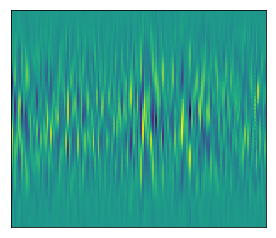

In [65]:
jjjjj = np.load('train_ffts.npy')
# jjjjj = np.swapaxes(jjjjj, 0, 1)
img = np.swapaxes(np.squeeze(jjjjj[0,:]), 0, 1)
print img.shape
plt.xticks([])
plt.yticks([])
plt.imshow(img)